# 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 모듈 import

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import random
import math

# 데이터 준비
### 데이터셋 폴더 관리 방법들
- 학습을 시작하기 전에 데이터셋을 관리하는 여러 방법들에 대해 살펴보겠음.
- 데이터셋을 관리하는 방법에는 여러 방법들이 존재하겠지만 내가 경험한 3가지 방법에 대해 설명하겠음.
- 방법1
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더의 하위 폴더에 label 이름을 가지는 폴더를 생성.
  - label 폴더 내부에 label에 해당하는 데이터 저장(이름의 형식은 상관없음.)
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 데이터 폴더명을 변수에 저장하여 label 이름으로 사용.
  - label 개수만큼 one-hot 형식의 target 정보를 생성.

- 방법2
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더에 "index_label이름.확장자" 형식의 데이터 저장.
  - 예시 : 0_dog, 1_cat, 2_horse, ..., 100_bird.png
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 데이터 로딩 과정에서 split 함수를 이용하여 데이터의 이름에서 label 이름을 분리하여 one-hot 형식의 target 정보를 생성.
  - 모든 데이터를 불러와야만 데이터 내부에 어떤 class 들이 존재하는지 알 수 있기 때문에 데이터 규모가 커지면 시간이 소요됨. 따라서 폴더 외부에 class 명을 따로 텍스트 파일로 저장.

- 방법3
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더에 "index.확장자" 형식의 데이터 저장.
  - 예시 : 0, 1, 2, ..., 100.png
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 폴더 외부에 데이터 관련 정보를 텍스트 파일로 저장.
  - 텍스트 파일 예시 : index, label, 필요 시 정보 추가 가능
  - 0, 1
  - 1, 9
  - 2, 5  
  .  
  .  
  .  
  - 100, 2
- 이번 exploration에서는 방법1로 제공된 데이터셋을 방법3에 맞게 변형하여 학습을 진행하도록 하겠음.

# EDA
- 사실 데이터를 가공하는 코드를 작성했는데 local 환경에서 코딩 후 colab에서 실행했더니 실행 속도가 너무 느려져서 colab에서는 가공된 결과를 다시 한번 살펴보는 것으로 코드를 대체 하겠음.

### 이미지 확인
- kaggle 학습용으로 정제된 데이터셋 사용
- 데이터는 가위, 바위, 보 클래스로 이루어져있으며 데이터 수, 데이터 shape 등에서 편향이 없음.
- 실제 사람의 손이 아닌 게임 시뮬레이션 화면을 사용한 듯 함.
- 이미지는 흰 배경이고 손목을 포함한 손이 화면 중앙에 위치함. 손의 사이즈에 따라서 손목이 안보이기도 함. 배경 변화에 취약할 것으로 예상함.
- 손은 기본적으로 손등이 노출된 형태이며 손등의 각도는 약간씩 틀어져있음. 손의 각도 변화에 취약할 것으로 예상함.
- 이미지별로 손가락의 길이, 피부색, 손톱색 등의 차이가 있음.
- 가위, 바위, 보의 모양에 차이가 있음.
- 모델 훈련 속도에 대한 고려와 exploration 과정을 따라가다보니 입력단을 28x28로 설정하였는데 이미지 resize 결과 손의 형태를 알아보기 어렵게 이미지가 다 뭉개졌음. 데이터셋 구성 시 여러 손 모양을 취한 의미가 많이 퇴색되었다고 생각함. 더 큰 입력 사이즈로의 변경이 필요하다고 생각함.

### 데이터 확인
- class의 종류 및 개수 파악 -> 3종, 약 3000장
- class별 데이터 개수 파악을 통한 데이터 편향 여부 확인 -> 데이터 편향 없음
- 이미지 shape이 통일되지 않은 데이터일 경우를 대비한 이미지 shape 분포 파악 -> 이미지 shape 모두 동일
- 데이터가 잘 정제되어 있음을 확인
- 각각의 class가 어떠한 이미지들로 구성되어 있는지 파악하기 위한 랜덤 샘플 시각화

### 데이터 전처리
- 이미지 resize 및 입력 데이터 정규화 과정 수행
  - 28x28 이미지로의 변환 및 입력값 범위 0 ~ 255 -> 0 ~ 1 변환
- one-hot 인코딩 생성
  - 처음에는 one-hot 인코딩 형태로 target을 생성하였으나 sparse_categorical_crossentropy 사용 시 자동으로 label을 one-hot 형태로 변경해주길래 그냥 사용 
- 데이터셋 분할
  - Train/Valid/Test 데이터를 0.6:0.2:0.2의 비율로 생성

In [3]:
# 폴더 경로
RSP_img_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/dataset/image'
RSP_label_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/dataset/label'

In [4]:
path = os.path.join(RSP_label_dir, "label.csv")
annotations = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/2892 [00:00<?, ?it/s]



클래스명 : paper, 이미지 개수 : 964 개 
클래스명 : rock, 이미지 개수 : 964 개 
클래스명 : scissors, 이미지 개수 : 964 개 


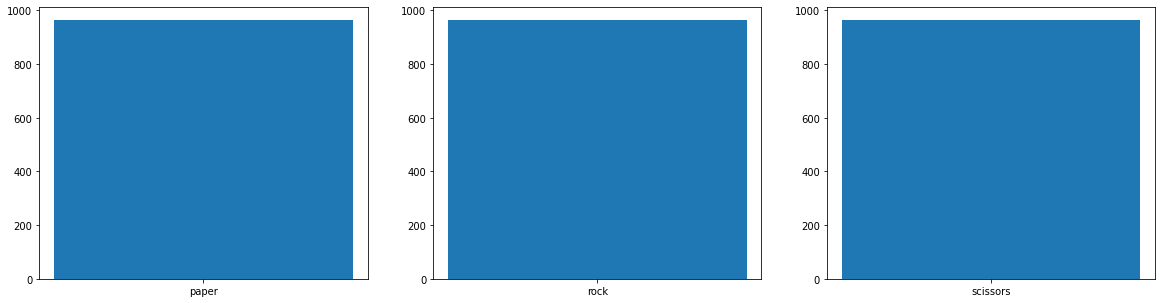

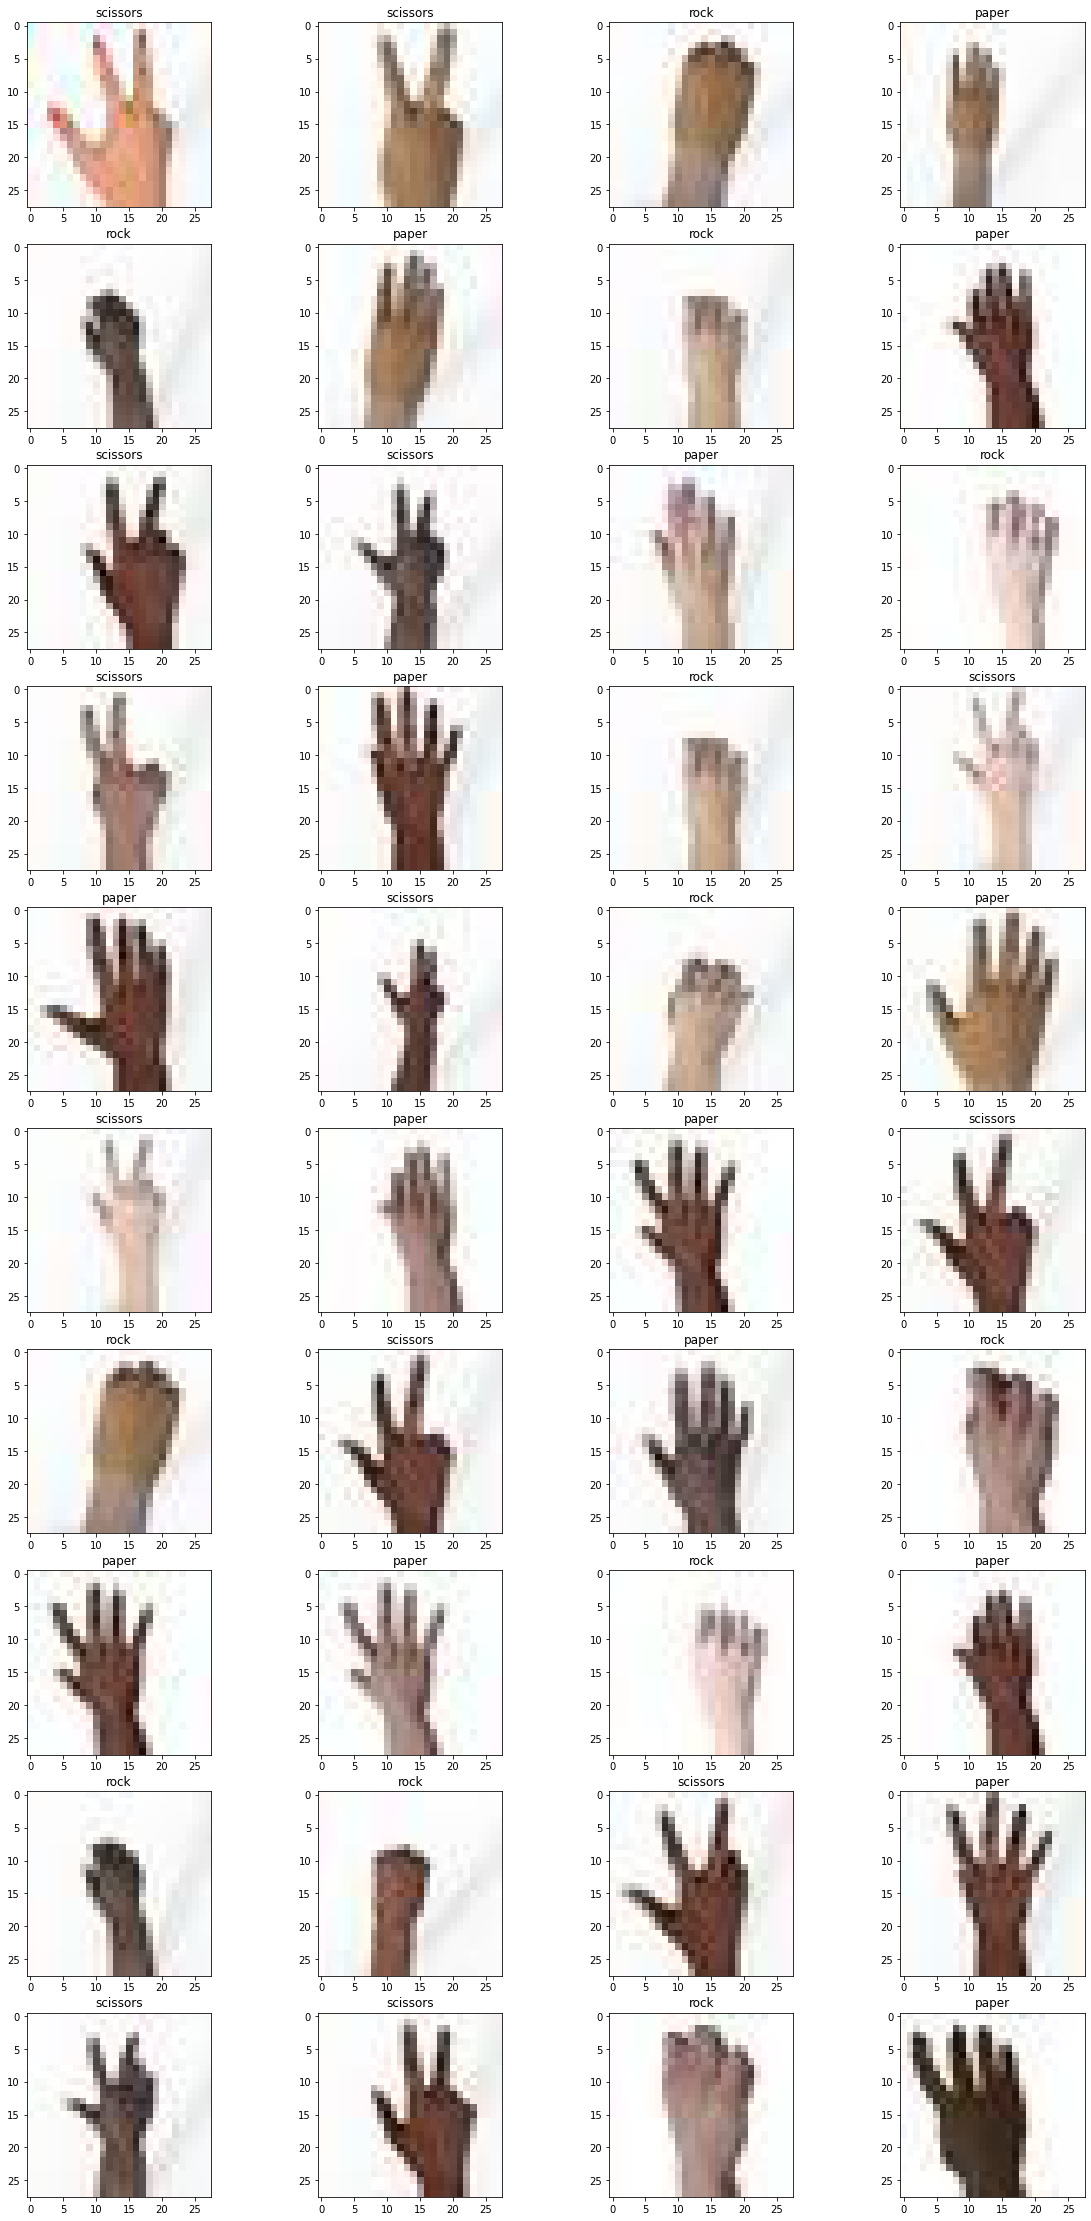

In [5]:
# label.csv 파일 내부의 파일명과 그에 대응하는 클래스명 불러오기
paths, labels = [], []
for idx, label in enumerate(tqdm_notebook(annotations.loc[:, "label"])):
    path = os.path.join(RSP_img_dir, str(idx) + ".JPEG")
    paths.append(path)
    labels.append(label)

# 클래스 중 유일한 값을 읽어 class명을 저장
class_names, class_cnts = np.unique(labels, return_counts=True)
print("\n")
for class_name, class_cnt in zip(class_names, class_cnts):
    print("클래스명 : {0}, 이미지 개수 : {1} 개 ".format(class_name, class_cnt))

i = 1
plt.figure(figsize=(20,5))
for class_name, class_cnt in zip(class_names, class_cnts):
    plt.subplot(1, 3, i)
    plt.bar(class_name, class_cnt)
    i += 1
plt.show()

# 이미지 시각화
random_sample_num = 40
random_sample_idx = random.sample(list(range(len(labels))), random_sample_num)

plt.figure(figsize=(20, random_sample_num))
for i, idx in enumerate(random_sample_idx):
    path = os.path.join(RSP_img_dir, str(idx) + ".JPEG")
    image = Image.open(path)
    plt.subplot(10, 4, i+1)
    plt.imshow(image)
    plt.title(labels[idx])
plt.show()

In [15]:
# Train, Valid, Test 데이터셋 분할 비율
ratios = [0.6, 0.2, 0.2]

train_cnt = int(len(paths) * ratios[0])
valid_cnt = int(len(paths) * ratios[1])
test_cnt = len(paths) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
print("데이터셋 분할 개수")
print("Train : {0} 개, Valid : {1} 개, Test : {2} 개".format(cnts[0], cnts[1], cnts[2]))

# 랜덤 인덱스 추출 후 데이터셋 분할
idx_range = list(range(len(paths)))
random.shuffle(idx_range)
idxs = [idx_range[:train_cnt], idx_range[train_cnt:train_cnt+valid_cnt], idx_range[train_cnt+valid_cnt:]]

def make_dataset(idxs, labels, class_names):
    x, y = [], []
    for idx in tqdm_notebook(idxs):
        image = Image.open(paths[idx])
        image = np.array(image, dtype=np.int32) / 255.0
        x.append(image)
        # one_hot = np.where(labels[idx] == class_names, 1, 0)
        one_hot = np.argmax(np.where(labels[idx] == class_names, 1, 0))
        y.append(one_hot)

    return x, y

x_train, y_train = make_dataset(idxs[0], labels, class_names)
x_valid, y_valid = make_dataset(idxs[1], labels, class_names)
x_test, y_test = make_dataset(idxs[2], labels, class_names)
    
print("x_train : {0} 개, y_train : {1} 개".format(len(x_train), len(y_train)))
print("x_valid : {0} 개, y_valid : {1} 개".format(len(x_valid), len(y_valid)))
print("x_test : {0} 개, y_test : {1} 개".format(len(x_test), len(y_test)))

데이터셋 분할 개수
Train : 1735 개, Valid : 578 개, Test : 579 개


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1735 [00:00<?, ?it/s]

  0%|          | 0/578 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

x_train : 1735 개, y_train : 1735 개
x_valid : 578 개, y_valid : 578 개
x_test : 579 개, y_test : 579 개


# 모델 생성
- 모델의 구성은 다음과 같은 방식을 걸쳐 설계하였음.
- DNN 보다 향상된 모델인 CNN을 적용하였으며 레이어가 진행됨에 따라 이미지의 차원이 감소할 수 있도록 2x2 stride를 적용하였음. maxpooling도 가능하지만 요새는 stride를 사용하는 추세인듯 함.
- 문제의 단순함을 고려하여 CNN 모델을 깊게 쌓지는 않음.
- 모델에서 overfitting을 방지하기 위한 방안으로 배치정규화 기법 혹은 드롭아웃 등을 적용 가능함. 이번에는 배치정규화 기법을 사용하였음.
- CNN 층 이후 softmax 적용을 위하여 DNN을 적용하였음.
- class 수가 적기 때문에 DNN 층을 1층만 적용하면 node가 너무 급격하게 줄어드는 느낌이 있어 중간에 DNN 층을 하나 추가함.
- 다중 분류 문제이기 때문에 마지막 활성화 함수는 softmax를 적용함.

In [83]:
# 하이퍼 파라미터 설정
n_channel_1 = 16
n_channel_2 = 32
n_dense_1 = 32
n_dense_2 = 10
class_num = 3

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(kernel_size=(3,3), filters=n_channel_1, strides=(2,2), padding='same', input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(kernel_size=(3,3), filters=n_channel_2, strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
model.add(keras.layers.Dense(class_num, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 14, 14, 16)        448       
                                                                 
 batch_normalization_14 (Bat  (None, 14, 14, 16)       64        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 14, 14, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 batch_normalization_15 (Bat  (None, 7, 7, 32)         128       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 7, 7, 32)         

# 학습 기준 설정 및 모델 훈련
- 학습을 반복적으로 진행하는 동안 경험적 근거를 바탕으로 하이퍼 파라미터를 아래의 셀과 같이 설정하였음.
- batch 사이즈는 학습량이 작기 때문에 어떤 값을 갖다 써도 학습 속도, loss, 컴퓨터 자원 활용 모든 면의 trade off에서 무방함.
- loss 함수는 softmax와 궁합이 좋은 cross-entropy 함수를 사용함.
- 매 epoch마다 학습의 진행도와 과적합 여부를 판단하기 위하여 valid 테스트를 진행함.

In [84]:
epochs=10
batch_size=16
learning_rate = 0.001

In [85]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_valid).shape)
print(np.array(y_valid).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(1735, 28, 28, 3)
(1735,)
(578, 28, 28, 3)
(578,)
(579, 28, 28, 3)
(579,)


In [86]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, validation_data=(x_valid, y_valid))

Epoch 1/10
109/109 [==============================] - 1s 5ms/step - loss: 0.4270 - accuracy: 0.8415 - val_loss: 1.1956 - val_accuracy: 0.4585
Epoch 2/10
109/109 [==============================] - 0s 4ms/step - loss: 0.0523 - accuracy: 0.9908 - val_loss: 0.4322 - val_accuracy: 0.9014
Epoch 3/10
109/109 [==============================] - 0s 4ms/step - loss: 0.0147 - accuracy: 0.9983 - val_loss: 0.1115 - val_accuracy: 0.9862
Epoch 4/10
109/109 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0415 - val_accuracy: 0.9931
Epoch 5/10
109/109 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 6/10
109/109 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/10
109/109 [==============================] - 0s 4ms/step - loss: 9.3976e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Ep

# 학습 모델 테스트
- 학습 결과 및 test 데이터셋 평가에서 정확도가 100%가 나옴.
- 과적합 여부를 판단하기 위해 train/valid 데이터셋의 loss 및 accuracy 측정 결과를 시각화 함.
- 시각화 결과 train 데이터셋 관련 지표의 그래프와 valid 데이터셋 관련 지표 그래프가 동시에 수렴하고 있기 때문에 과적합이라고 볼 수 없음.
- 이와 동시에 사람의 시각적 평가를 진행하였음.
- 랜덤 샘플을 추출하여 시각 평가를 해본 결과 모두 정답이라고 평가함. 중간에 따봉 모양을 하는 주먹이 있는데 원본 이미지를 확인해본 결과 정답이 맞음.

In [88]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {0} ".format(round(test_loss, 2)))
print("test_accuracy: {0}".format(round(test_accuracy, 2)))

19/19 - 0s - loss: 0.0023 - accuracy: 0.9983 - 59ms/epoch - 3ms/step
test_loss: 0.0 
test_accuracy: 1.0


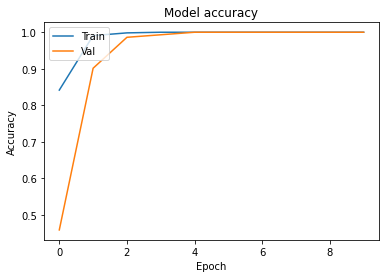

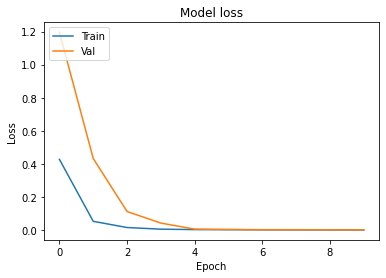

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [90]:
pred = model.predict(x_test)

In [91]:
class_names

array(['paper', 'rock', 'scissors'], dtype='<U8')

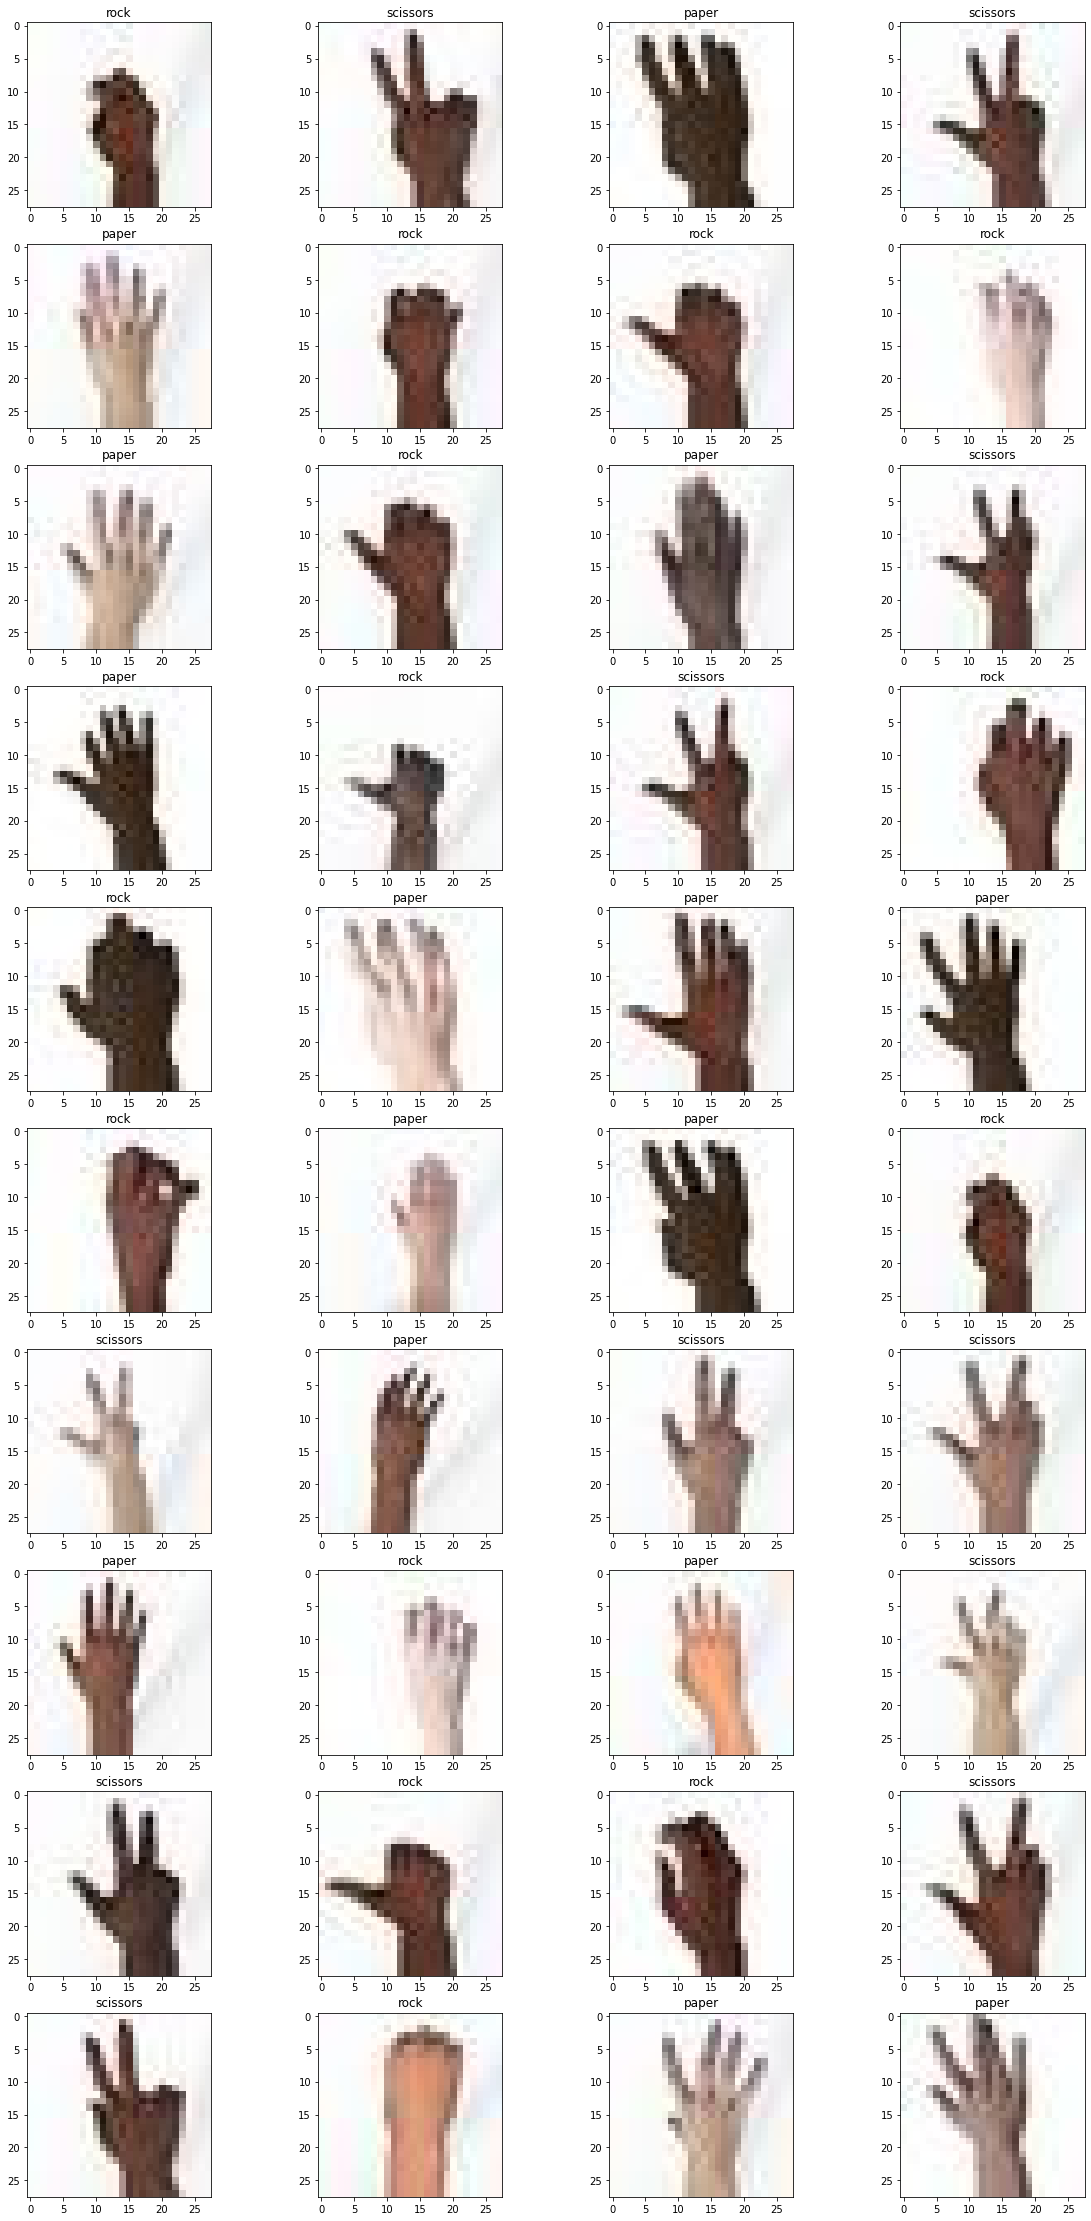

In [92]:
i = 0
plt.figure(figsize=(20, 40))
for i in range(40):
    plt.subplot(10, 4, i+1)
    plt.imshow(x_test[i])
    title = class_names[np.argmax(pred[i])]
    plt.title(title)
plt.show()

# 추가 작업 수행
- 앞서 훈련한 모델의 성능이 너무 좋아서 일부러 성능이 좋지 않은 모델을 만들어서 모델 평가를 진행해보겠음.

In [101]:
# 하이퍼 파라미터 설정
n_channel_1 = 8
n_dense_1 = 10
class_num = 3

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(kernel_size=(3,3), filters=n_channel_1, strides=(2,2), padding='same', input_shape=(28,28,3)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
model.add(keras.layers.Dense(class_num, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 14, 14, 8)         224       
                                                                 
 activation_22 (Activation)  (None, 14, 14, 8)         0         
                                                                 
 flatten_12 (Flatten)        (None, 1568)              0         
                                                                 
 dense_34 (Dense)            (None, 10)                15690     
                                                                 
 dense_35 (Dense)            (None, 3)                 33        
                                                                 
Total params: 15,947
Trainable params: 15,947
Non-trainable params: 0
_________________________________________________________________


In [102]:
epochs=6
batch_size=16
learning_rate = 0.001

In [103]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, validation_data=(x_valid, y_valid))

Epoch 1/6
109/109 [==============================] - 1s 5ms/step - loss: 1.0421 - accuracy: 0.4617 - val_loss: 0.9163 - val_accuracy: 0.5848
Epoch 2/6
109/109 [==============================] - 0s 3ms/step - loss: 0.7853 - accuracy: 0.6772 - val_loss: 0.6915 - val_accuracy: 0.7266
Epoch 3/6
109/109 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.8144 - val_loss: 0.4917 - val_accuracy: 0.8754
Epoch 4/6
109/109 [==============================] - 0s 4ms/step - loss: 0.4262 - accuracy: 0.8703 - val_loss: 0.4318 - val_accuracy: 0.8581
Epoch 5/6
109/109 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.9032 - val_loss: 0.3140 - val_accuracy: 0.9187
Epoch 6/6
109/109 [==============================] - 0s 4ms/step - loss: 0.2745 - accuracy: 0.9251 - val_loss: 0.2553 - val_accuracy: 0.9256


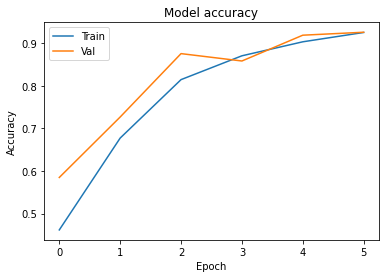

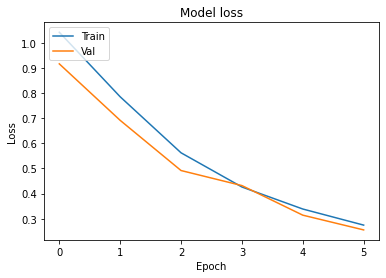

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [145]:
pred = model.predict(x_test)

In [146]:
pred

array([[2.9956199e-02, 9.5710826e-01, 1.2935504e-02],
       [2.9747239e-03, 9.2297249e-02, 9.0472800e-01],
       [9.2585701e-01, 7.3670313e-02, 4.7268870e-04],
       ...,
       [3.1017900e-02, 7.8222997e-02, 8.9075911e-01],
       [4.4658829e-02, 9.5525312e-01, 8.8018147e-05],
       [2.2399561e-02, 3.8386565e-02, 9.3921393e-01]], dtype=float32)

In [166]:
truth = np.zeros((len(y_test), 3))
for i, idx in enumerate(y_test):
    truth[i, idx] = 1

confusion_matrix_df = pd.DataFrame(data=np.zeros((3, 3)),
                                   index=['true_paper', 'true_rock', 'true_scissors'],
                                   columns=['pred_paper', 'pred_rock', 'pred_scissors'])

pred2 = np.argmax(pred, axis=-1)
pred2
false_data_idx = []

img_idx = 0 
for i, j in zip(y_test, pred2):
    confusion_matrix_df.iloc[i, j] += 1
    if i != j:
        false_data_idx.append([img_idx, i, j])
    img_idx += 1

In [167]:
confusion_matrix_df

,pred_paper,pred_rock,pred_scissors
true_paper,177.0,11.0,11.0
true_rock,17.0,167.0,10.0
true_scissors,0.0,4.0,182.0


In [168]:
print("오답의 개수 :", len(false_data_idx))

오답의 개수 : 53


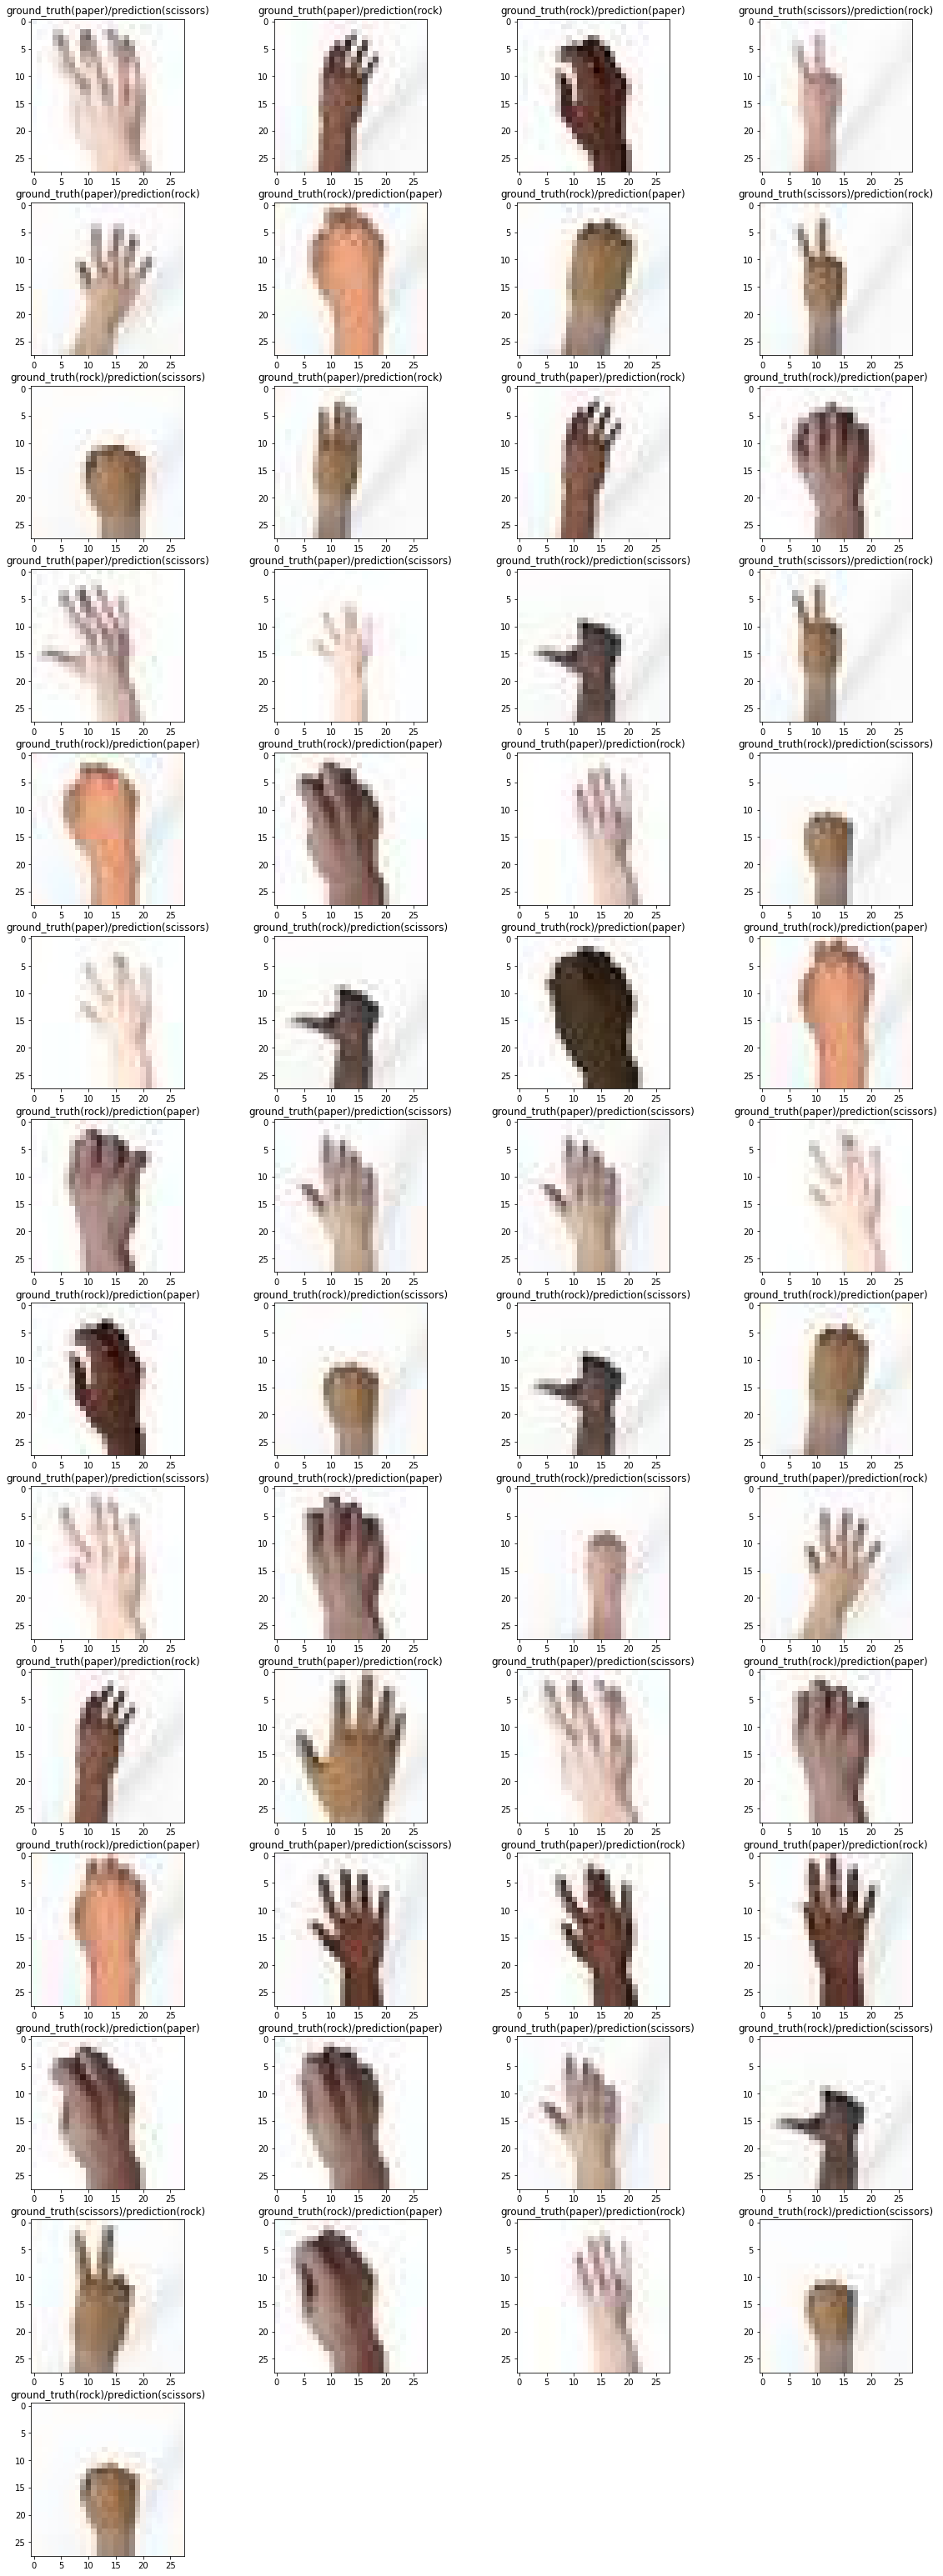

In [170]:
row_num = math.ceil(len(false_data_idx) / 4)

plt.figure(figsize=(20, 4*row_num))
for i, coord in enumerate(false_data_idx):
    img_idx, truth_idx, pred_idx = coord
    plt.subplot(row_num, 4, i+1)
    plt.imshow(x_test[img_idx])
    plt.title("ground_truth({0})/prediction({1})".format(class_names[truth_idx], class_names[pred_idx]))
plt.show()

# 결과 분석
- CNN 레이어 수 감소와 filter 개수 감소를 통해 모델을 단순화하고 학습 회수를 절반 가량 줄인 결과 모델의 성능이 낮아졌음을 확인함.
- 성능 저하 원인에 대하여 confusion matrix와 오답 이미지의 시각화를 통해 원인을 분석해 보겠음.
- 우선 confusion matrix의 대각 성분이 정답이며 그 외의 수치는 이미지를 어떻게 오판 하였는지 보여줌. 총 오답 이미지는 53개이며 그에 대한 시각화를 해보았음.
- 오답 이미지들의 예시를 들어보면 아래와 같음
  - 큰 주먹을 작은 보로 착각함.
  - 엄지를 핀 주먹을 가위로 착각함.
  - 작은 주먹을 가위로 착각함.
  - 작은 보를 가위로 착각함.
- 모델을 단순화 시키는 과정에서 모델이 사실상 DNN 모델에 근접했기 때문에 이미지에서 0이 아닌 데이터가 분포된 공간을 인지하는 능력만이 남았을 것이라고 추론함(CNN 레이어를 사용하면 이미지의 형태나 위치를 파악하는 능력이 생김). -> 오답의 이미지를 블러처리하여 모서리를 뭉뚱하게 만들면 왜 잘못 예측했는지 추측 가능.

# 회고
- 루브릭 기준 만족 여부
  - 트레이닝 정상 수행 여부 : 만족
  - 오버피팅 극복 시도 : 일부 수행
    - 폭 넓은 빅데이터(x), 데이터 증강(x)
    - 배치 정규화(o), 드롭아웃(x), L1/L2 norm(x), 모델 차원 감소(o)
    - valid test 수행 및 학습 조기 종료(o)
  - test accuracy 60% 이상: 테스트 결과 100%로 만족

- 데이터를 다루는 3가지 방법을 제시하고 그 중 한가지 방법을 채택하여 데이터를 저장, 로드, 전처리를 수행하였음.
- 학습 전 데이터의 적절성을 판단하기 위하여 EDA를 수행하였으며 여러 방향에서 적절성 여부를 평가하였음.
- 여러 가설과 반복적 학습 수행 결과를 바탕으로 모델의 구조와 하이퍼 파라미터를 조정하였음(최적화 수준까지는 아닌듯 함).
- 1차 학습 결과 정확도 100%에 대한 분석
  - 데이터셋은 클래스 별로 1000장이며 적은 수의 데이터셋은 아니지만 실제 데이터를 살펴보면 1000장 중 비슷한 이미지가 대부분이며 이미지 모양의 변동 폭이 좁음. 이를 이용한 학습은 사실상 동일한 이미지 몇장만을 반복 학습시키는 결과라고 볼 수 있음.
  - 데이터의 클래스가 적으며 클래스 간의 이미지 유사도가 낮음. 배경, 손의 각도, 손의 중심 좌표, 손의 크기 등에서는 변동 폭이 거의 없음. 손의 색상과 모양에만 차이점이 있다고 볼 수 있음. 따라서 분류의 난이도가 상당히 낮은 문제였음.
- 2차 학습 결과 분석
  - 모델을 사실상 DNN 모델로 동작하게 설정하여 이미지의 좌표 분포만을 학습시킴.
- 과적합에 대한 평가
  - 이번 학습에서는 실제 손 사진을 이용하는 대신 kaggle 데이터셋을 사용하였음.
  - 문제 자체가 단순하며 잘 정제된 데이터였기 때문에 모델의 정확도가 엄청나게 놓게 나옴.
  - 정확도가 높다고 해서 그것이 과적합을 의미하지는 않음. 전체 데이터셋을 의도적으로 제한했으며 그 안에서는 정상적으로 예측이 이뤄지고 있기 때문임.
  - train/valid test history 그래프를 통하여 두 그래프 상의 차이가 없었으며 사람이 테스트한 결과에서도 오판은 없었음.
- 앞으로의 개선점
  - 패키지 함수를 쓰다보니 수행할 수 있는 명령에 제한이 있었음. 다음 과정에서는 커스텀 함수를 사용해서 더 다양한 기능을 구사해보겠음.
  - 데이터의 수/데이터의 다양성 증가, 데이터 증강 기법을 통해 문제의 난이도를 높이고 문제를 해결하기 위해 여러 기법 적용과 분석을 진행해보겠음. 이번 문제는 문제 난이도가 너무 낮아서 많은 시도를 하지 못함.